# Collecting Data from Visible and Thermal Cameras from Plants

In [1]:
import sys
sys.path.append('../')

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
from IPython import display
import ipywidgets as wd

import cv2
from cameras.ids_ueye import uEye
from cameras.boson_grabber import BosonFrameGrabber
# from cameras.utils import create_preview_frame
import dlipower

from skimage.exposure import rescale_intensity, equalize_adapthist, equalize_hist
from skimage.transform import resize

## Initialize Hardware

In [3]:
vis_cam_obj = uEye()
vis_cam_obj.set_exposure(200)

Number of parameter sets: 1
Loaded parameter set 0
Camera initialized and has exposure range: [0.0549, 200.97245] ms
Exposure set to 199.99945000000002 ms


199.99945000000002

In [4]:
thr_cam_obj = BosonFrameGrabber()
thr_cam_obj.start_grabber()
thr_cam_obj.camera.do_ffc()

Camera disconnected


In [5]:
switch = dlipower.PowerSwitch(hostname="192.168.0.100", userid="admin", password="4321")
print(switch)

DLIPowerSwitch at 192.168.0.100
Outlet	Name           	State
1	Outlet 1       	OFF
2	Outlet 2       	OFF
3	Outlet 3       	OFF
4	Outlet 4       	OFF
5	Outlet 5       	OFF
6	Outlet 6       	ON
7	Outlet 7       	OFF
8	Outlet 8       	OFF



In [6]:
def create_preview_frame(frame_raw: np.ndarray, in_range='image'):
    frame = rescale_intensity(frame_raw.astype(float), in_range=in_range, out_range=(0, 1.0))
    frame = frame * 255
    # frame = equalize_adapthist(frame, clip_limit=0.01) * 255
    # frame = equalize_hist(frame) * 255
    frame = frame.astype(np.uint8)
    frame = cv2.applyColorMap(frame, cv2.COLORMAP_TURBO)[..., ::-1]
    return frame

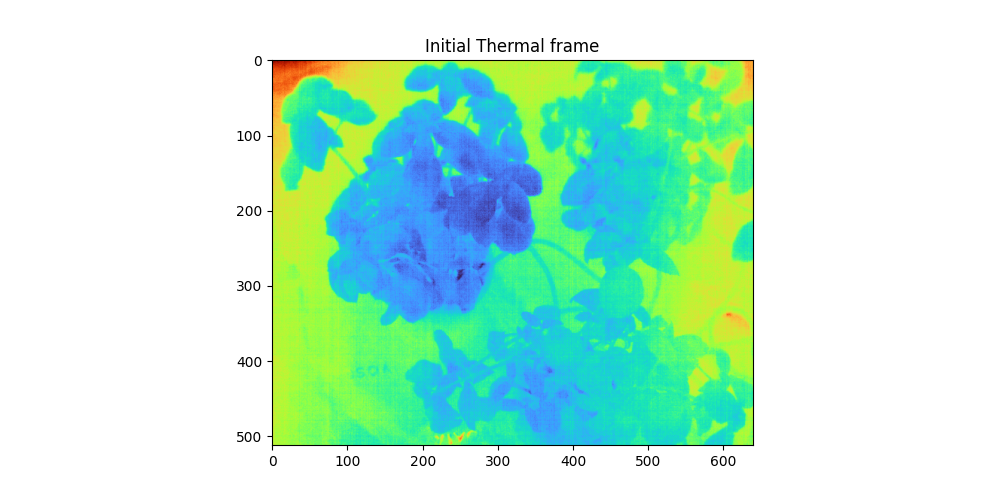

In [7]:
num_init = 100
init_frame = np.zeros((512, 640), dtype=np.float32)
for _ in range(num_init):
    frame_init, _ = thr_cam_obj.get_latest_frame()
    frame_init = frame_init[:, ::-1]
    init_frame += frame_init
init_frame /= num_init

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.imshow(create_preview_frame(init_frame))
ax.set_title('Initial Thermal frame')
plt.show()

KeyboardInterrupt: 

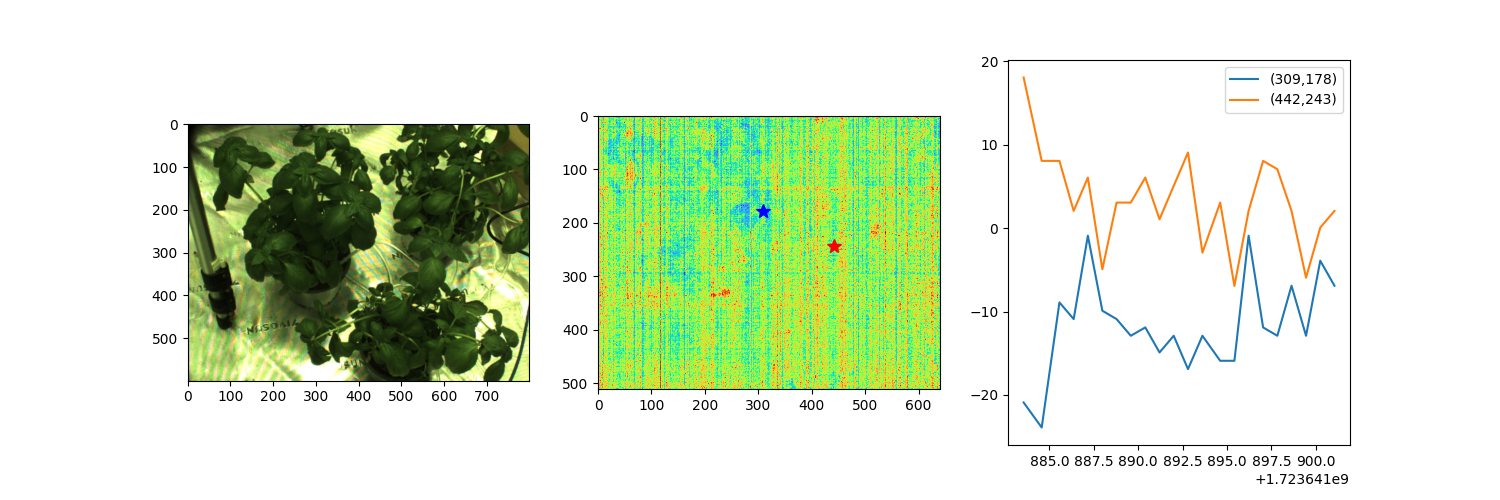

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# thr_cam_obj.camera.do_ffc()
vis_cam_obj.set_exposure(10)

pixel_val1 = []
pixel_val2 = []
tstamp = []
py1, px1 = 178, 309
py2, px2 = 243, 442

tic = time.time()
light_on = False
light_toggle = False
dt = 10


while True:

    if light_toggle:
        if time.time() - tic > dt:
            light_on = not light_on
            if light_on:
                switch.on(1)
                dt = 10
            else:
                switch.off(1)
                dt = 40
            tic = time.time()
    
    vis_img, vis_tstamp = vis_cam_obj.getNextImage(), time.time()
    thr_img, thr_tstamp = thr_cam_obj.get_latest_frame()

    vis_img_color = np.floor(cv2.cvtColor(vis_img, cv2.COLOR_BayerRGGB2BGR) / 16).astype(np.uint8)[..., ::-1]
    thr_img = thr_img[:, ::-1]
    thr_img_viz = thr_img - init_frame
    # thr_img_viz = thr_img[:, :350]
    pixel_val1.append(thr_img_viz[py1, px1])
    pixel_val2.append(thr_img_viz[py2, px2])
    tstamp.append(thr_tstamp)

    min_val, max_val = np.percentile(thr_img_viz, [1, 99])
    thr_img_viz = rescale_intensity(thr_img_viz, in_range=(min_val, max_val), out_range=(0, 1.0))*255
    thr_img_viz = thr_img_viz.astype(np.uint8)

    axes[0].clear()
    axes[0].imshow(vis_img_color)
    axes[1].clear()
    axes[1].imshow(thr_img_viz, cmap='turbo')
    axes[1].plot(px1, py1, 'b*', markersize=10)
    axes[1].plot(px2, py2, 'r*', markersize=10)
    axes[2].clear()
    axes[2].plot(tstamp, pixel_val1, label="({},{})".format(px1, py1))
    axes[2].plot(tstamp, pixel_val2, label="({},{})".format(px2, py2))
    axes[2].legend()
    display.clear_output(wait=True)
    display.display(plt.gcf())

In [10]:
data_slug = "basil_3plants_heatlamp"

In [11]:
num_initial_frames = 360
num_light_pulses = 3
light_on_frame = 60
light_off_frame = 660
num_thr_frames = 3060
num_final_frames = 360

output_filename_slug = f'../data/plant_data_{data_slug}_{time.time()}_'

vis_cam_obj.set_exposure(10)
all_visible_frames = []
all_visible_tstamps = []

print(f"Collecting initial thermal frames")
initial_frames = []
initial_tstamps = []
for iter in range(num_initial_frames):
    if iter == 9:
        thr_cam_obj.camera.do_ffc()
    frame, tstamp = thr_cam_obj.get_latest_frame()
    initial_frames.append(frame)
    initial_tstamps.append(tstamp)

    if iter % 60 == 59:
        vis_frame, vis_tstamp = vis_cam_obj.getNextImage(), time.time()
        all_visible_frames.append(vis_frame)
        all_visible_tstamps.append(vis_tstamp)
initial_frames = np.stack(initial_frames, axis=-1)
initial_tstamps = np.array(initial_tstamps)

output_filename = output_filename_slug + 'initial.npz'
np.savez(output_filename, initial_frames=initial_frames, initial_tstamps=initial_tstamps, all_visible_frames=all_visible_frames, all_visible_tstamps=all_visible_tstamps)

all_visible_frames = []
all_visible_tstamps = []
all_thr_frames = []
all_thr_tstamps = []
for pulse in range(num_light_pulses):
    print(f"Collecting {num_thr_frames} thermal frames")
    thr_frames = []
    thr_tstamps = []
    for iter in range(num_thr_frames):
        if iter == light_on_frame:
            switch.on(1)
        if iter == light_off_frame:
            switch.off(1)
        frame, tstamp = thr_cam_obj.get_latest_frame()
        thr_frames.append(frame)
        thr_tstamps.append(tstamp)

        if iter % 60 == 59:
            vis_frame, vis_tstamp = vis_cam_obj.getNextImage(), time.time()
            all_visible_frames.append(vis_frame)
            all_visible_tstamps.append(vis_tstamp)
    thr_frames = np.stack(thr_frames, axis=-1)
    thr_tstamps = np.array(thr_tstamps)
    all_thr_frames.append(thr_frames)
    all_thr_tstamps.append(thr_tstamps)
all_thr_frames = np.stack(all_thr_frames, axis=0)
all_thr_tstamps = np.stack(all_thr_tstamps, axis=0)
all_visible_frames = np.stack(all_visible_frames, axis=0)
all_visible_tstamps = np.array(all_visible_tstamps)

output_filename = output_filename_slug + 'pulses.npz'
np.savez(output_filename, all_thr_frames=all_thr_frames, all_thr_tstamps=all_thr_tstamps, all_visible_frames=all_visible_frames, all_visible_tstamps=all_visible_tstamps)

print(f"Collecting final thermal frames")
all_visible_frames = []
all_visible_tstamps = []
final_frames = []
final_tstamps = []
for iter in range(num_final_frames):
    if iter == 9:
        thr_cam_obj.camera.do_ffc()
    frame, tstamp = thr_cam_obj.get_latest_frame()
    final_frames.append(frame)
    final_tstamps.append(tstamp)

    if iter % 60 == 59:
        vis_frame, vis_tstamp = vis_cam_obj.getNextImage(), time.time()
        all_visible_frames.append(vis_frame)
        all_visible_tstamps.append(vis_tstamp)
final_frames = np.stack(final_frames, axis=-1)
final_tstamps = np.array(final_tstamps)
all_visible_frames = np.stack(all_visible_frames, axis=0)
all_visible_tstamps = np.array(all_visible_tstamps)

output_filename = output_filename_slug + 'final.npz'
np.savez(output_filename, final_frames=final_frames, final_tstamps=final_tstamps, all_visible_frames=all_visible_frames, all_visible_tstamps=all_visible_tstamps)


# # will cover 0.05ms to ~10ms
# num_frames_vis = 15
# base_exposure = 0.05
# exponent = 1.8
# print(f"Collecting {num_frames_vis} visible frames")
# vis_frames = []
# vis_tstamps = []
# exposures = []
# for i in range(num_frames_vis):
#     exposure_val = base_exposure * exponent**i
#     actual_exposure_val = vis_cam_obj.set_exposure(exposure_val)

#     frame = vis_cam_obj.getNextImage()
#     vis_frames.append(frame)
#     vis_tstamps.append(time.time())
#     exposures.append(actual_exposure_val)
# vis_frames = np.stack(vis_frames, axis=-1)
# vis_tstamps = np.array(vis_tstamps)
# exposures = np.array(exposures)

# output_filename = f'../data/visible_video_{data_slug}_{time.time()}.npz'
# np.savez(output_filename, vis_frames=vis_frames, vis_tstamps=vis_tstamps, exposures=exposures)

Exposure set to 10.000350000000001 ms


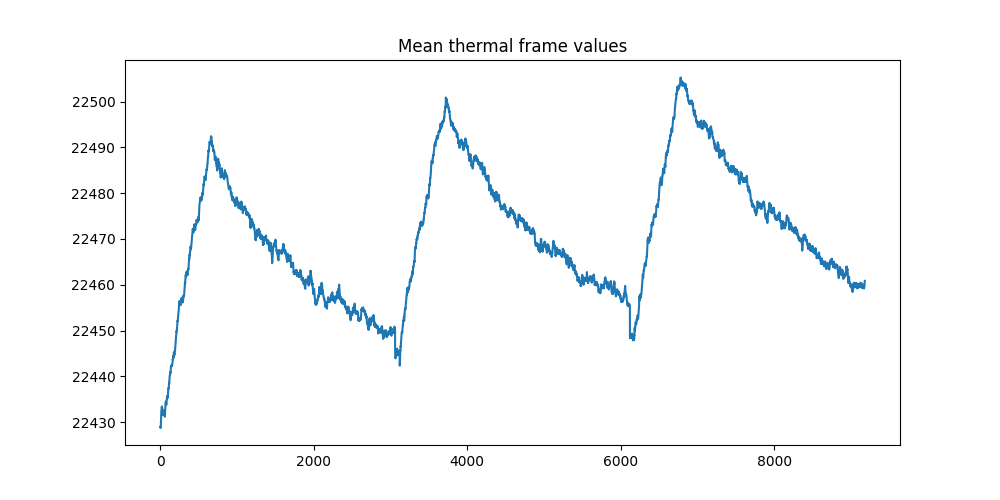

In [15]:
mean_thr_frames_values = np.mean(all_thr_frames, axis=(1, 2)).flatten()

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(mean_thr_frames_values)
ax.set_title('Mean thermal frame values')
plt.show()

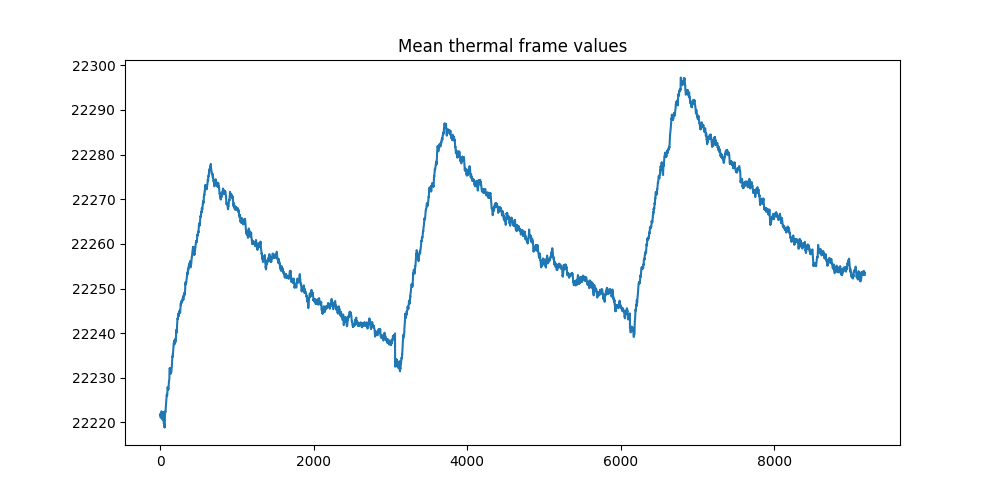

In [12]:
mean_thr_frames_values = np.mean(all_thr_frames, axis=(1, 2)).flatten()

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(mean_thr_frames_values)
ax.set_title('Mean thermal frame values')
plt.show()